✅ Model Evaluation Results (XGBoost)
-------------------------------------------------
📉 Mean Absolute Error (MAE): 342.22 Crore
📈 R² Score: 0.72
🎯 Approximate Accuracy: 71.56%
-------------------------------------------------

🏠 Sample Testing Results (first 10 rows):
   Actual Price (Crore)  Predicted Price (Crore)       Error
0                 220.0               204.124756   15.875244
1                 350.0               391.482452   41.482452
2                8600.0              8614.124023   14.124023
3                1080.0              1283.262939  203.262939
4                 150.0               190.457275   40.457275
5                 950.0               763.287415  186.712585
6                1585.0              1576.016235    8.983765
7                2200.0              2836.343994  636.343994
8                5500.0              5742.707031  242.707031
9                4000.0              3885.028809  114.971191


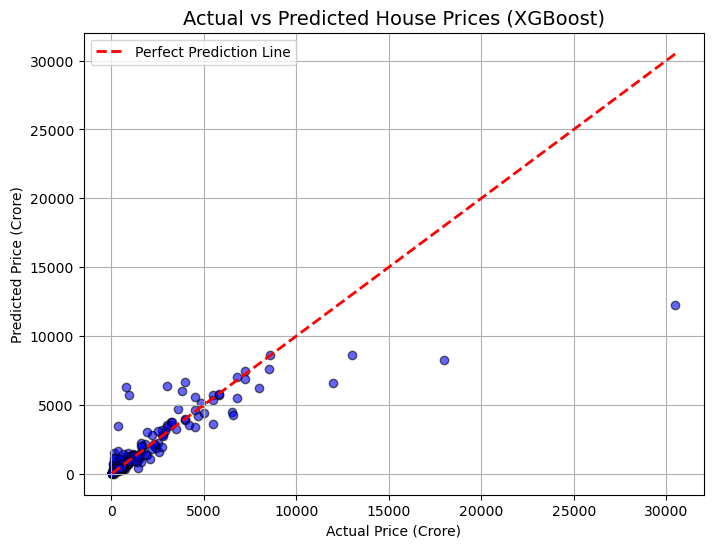

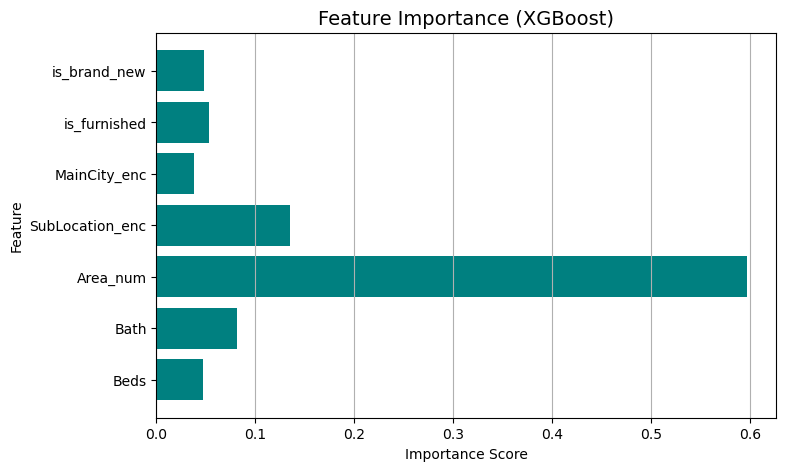


💰 Predicted Price for Sample House: 492.49 Crore


In [ ]:
# ============================================
# STEP 0: Install & Import Libraries
# ============================================
# !pip install xgboost openpyxl --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# ============================================
# STEP 1: Load Dataset
# ============================================
df = pd.read_excel(r"C:\Users\Rashid\Downloads\Zameen.xlsx")
# df = pd.read_excel(r"C:\Users\Rashid\Downloads\Zameen.xlsx")

# ============================================
# STEP 2: Data Cleaning / Feature Extraction
# ============================================
def convert_area(area):
    area = str(area).lower().replace(" marla", "").strip()
    try:
        return float(area)
    except:
        return np.nan
df["Area_num"] = df["Area"].apply(convert_area)


def convert_price(price):
    price = str(price).lower().replace(" crore", "").strip()
    try:
        return float(price)
    except:
        return np.nan

df["Price_num"] = df["Price"].apply(convert_price)

# Extract location details
df["MainCity"] = df["Location"].apply(lambda x: str(x).split(",")[-1].strip())
df["SubLocation"] = df["Location"].apply(lambda x: str(x).split(",")[0].strip())

# Encode categorical variables
le_sub = LabelEncoder()
le_city = LabelEncoder()
df["SubLocation_enc"] = le_sub.fit_transform(df["SubLocation"])
df["MainCity_enc"] = le_city.fit_transform(df["MainCity"])

# Extract text-based features
df["is_furnished"] = df["Title"].str.contains("furnished", case=False, na=False).astype(int)
df["is_brand_new"] = df["Title"].str.contains("brand new", case=False, na=False).astype(int)

# ============================================
# STEP 3: Select Features for Model
# ============================================
df_cleaned = df.dropna(subset=['Price_num', 'Area_num']).copy()

X = df_cleaned[[
    "Beds", "Bath", "Area_num",
    "SubLocation_enc", "MainCity_enc",
    "is_furnished", "is_brand_new"
]]
y = df_cleaned["Price_num"]

# ============================================
# STEP 4: Train-Test Split
# ============================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ============================================
# STEP 5: Scaling
# ============================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
import pickle
pickle.dump(scaler,open('scaling.pkl','wb'))

# ============================================
# STEP 6: XGBoost Model
# ============================================
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

model.fit(X_train_scaled, y_train)

# ============================================
# STEP 7: Evaluate Model
# ============================================
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = 100 - (mae / y_test.mean() * 100)

print("✅ Model Evaluation Results (XGBoost)")
print("-------------------------------------------------")
print(f"📉 Mean Absolute Error (MAE): {mae:.2f} Crore")
print(f"📈 R² Score: {r2:.2f}")
print(f"🎯 Approximate Accuracy: {accuracy:.2f}%")
print("-------------------------------------------------\n")

# ============================================
# STEP 8: Actual vs Predicted Results
# ============================================
results = pd.DataFrame({
    "Actual Price (Crore)": y_test.values,
    "Predicted Price (Crore)": y_pred
})
results["Error"] = abs(results["Actual Price (Crore)"] - results["Predicted Price (Crore)"])

print("🏠 Sample Testing Results (first 10 rows):")
print(results.head(10))

# ============================================
# STEP 9: Visualization - Actual vs Predicted Graph
# ============================================
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction Line')
plt.title("Actual vs Predicted House Prices (XGBoost)", fontsize=14)
plt.xlabel("Actual Price (Crore)")
plt.ylabel("Predicted Price (Crore)")
plt.legend()
plt.grid(True)
plt.show()

# ============================================
# STEP 10: Feature Importance Graph
# ============================================
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8,5))
plt.barh(feature_names, importances, color='teal')
plt.title("Feature Importance (XGBoost)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis='x')
plt.show()

# ============================================
# STEP 11: Predict New Example
# ============================================
sample = pd.DataFrame([{
    "Beds": 5,
    "Bath": 6,
    "Area_num": 10,
    "SubLocation_enc": le_sub.transform(["Top City 1"])[0] if "Top City 1" in le_sub.classes_ else 0,
    "MainCity_enc": le_city.transform(["Islamabad"])[0] if "Islamabad" in le_city.classes_ else 0,
    "is_furnished": 1,
    "is_brand_new": 1
}])

sample_scaled = scaler.transform(sample)
predicted_price = model.predict(sample_scaled)[0]
print(f"\n💰 Predicted Price for Sample House: {predicted_price:.2f} Crore")
# print(sample_scaled)




# **Pickling the model file for production**

In [3]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))
pickled_model=pickle.load(open('model.pkl', 'rb'))
pickled_model.predict(sample_scaled)


array([4.8780456], dtype=float32)